In [25]:
## Explainability
#!pip install -r requirements.txt --user
#!pip install numpy
import pandas as pd
import numpy as np
import matplotlib
from helpful_util import load_models_lendingclub, display_sklearn_feature_importance, Perturb, save_obj, load_obj
import warnings
warnings.filterwarnings('ignore')
import keras
import lime
import lime.lime_tabular
%matplotlib inline

In [28]:
#Loading COO Matrices - sparse with OHE of all original Features
#Load UDFs to use later. 
    

#Keras and Sklearn have different ways of showing prediction probabilities. Keras == model.predict, sklearn == model.predict_proba
def explain_lime(model, train, test, observation, seed = 1, num_features = 10):
    '''
    Parameters:
        model: object,
            Random Forest: rfc
            Gradient Boosted Classifier: gbc
            Logistic Regression: logit
            Keras Neural Network = keras_ann
            Sklearn Neural Network = sk_ann
        train: object; train set dataframe
        test: object; test set dataframe
        observation: int (index of explanation on test data set)
        seed: int; default to 1
        num_features: int, the number of features to be displayed in explanation
        
    Returns:
        Local explanations over test set - Summary
    '''
    np.random.seed(seed)
    i = observation
    
    if type(model) == keras.engine.sequential.Sequential:
        predict_fn = lambda x: model.predict(encoder.transform(x).toarray())
    else:
        predict_fn = lambda x: model.predict_proba(encoder.transform(x)).astype(float)

    explainer = lime.lime_tabular.LimeTabularExplainer(
        train,
        feature_names=feature_names,
        class_names=class_names,
        categorical_features=categorical_features,
        categorical_names=categorical_names,
        kernel_width=3)

    
    exp = explainer.explain_instance(test[i], predict_fn, num_features= num_features)
    exp.show_in_notebook(show_all=True)

    print('-' * 125)    
    print('Model: {}'.format(models[str(type(model))][0]))
    print("Looking at Observation: {}".format(i))
    print("Actual Class Label: {}".format(y_test[i]))   
    %matplotlib inline
    try: #If Keras
        print("Predicted Class Label: {}".format(np.argmax(model.predict(encoder.transform(test).toarray()),axis = 1)[i]))
        print("Prediction Confidence (Prob): {0:.2f}%".format(np.max(model.predict(encoder.transform(test).toarray())[i]*100)))
        print('-' * 125)
        print("Displaying Local Explanation for Prediction......")
    except: #If Sklearn
        print("Predicted Class Label: {}".format(np.argmax(model.predict_proba(encoder.transform(test[i].reshape(1,-1))).astype(float))
        ))
        print("Prediction Confidence (Prob): {0:.2f}%".format(np.max(model.predict_proba(encoder.transform(test[i].reshape(1,-1)))[0])*100))
        print('-' * 125)
        print("Displaying Local Explanation for Prediction: Top {} Features......".format(num_features))
    fig = exp.as_pyplot_figure()

    
#Load Data Objects. Stored these locally/remotely to avoid dependency issues
#list of all features used
feature_names = [
    'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
    'emp_length', 'home_ownership', 'annual_inc', 'title', 'inq_last_6mths',
    'revol_bal', 'total_pymnt', 'total_rec_late_fee', 'last_pymnt_amnt',
    'acc_open_past_24mths', 'delinq_amnt', 'tax_liens', 'tot_hi_cred_lim',
    'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
    'loan_condition'
]

#List only Continuous Feats.
continuous = [
    'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'inq_last_6mths',
    'revol_bal', 'total_pymnt', 'total_rec_late_fee', 'last_pymnt_amnt',
    'acc_open_past_24mths', 'delinq_amnt', 'tax_liens', 'tot_hi_cred_lim',
    'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit'
]

#Load Models
rfc, gbc, logit, keras_ann, sk_ann = load_models_lendingclub()

#indices of cat features
categorical_features = [1, 4, 5, 6, 7, 9]  #Get Nominal / Ordinal / etc..

#Load Dictionary of categorical features after encoded. Need this for Lime
categorical_names = load_obj('data_objects/categorical_names')

#all features as a list. Unwrapping encoding
features = []
for k in categorical_names.values():
    for i in k:
        features.append(i)

#Clean up Feats
features[:2] = ['Term:' + i for i in features[:2]]
features[2:9] = ['Loan_Grade:' + i for i in features[2:9]]
features[9:44] = ['Loan_SubGrade:' + i for i in features[9:44]]
features[44:56] = ['Employment_Length:' + i for i in features[44:56]]
features[56:60] = ['Home_Ownership:' + i for i in features[56:60]]
features[60:] = ['Loan_Title:' + i for i in features[60:]]
#Concatenate encoded features + continuous features
features = features + continuous

#Load necessary data objects. Pre encoded Data
X_train = load_obj('data_objects/X_train')
X_test = load_obj('data_objects/X_test')
y_train = load_obj('data_objects/y_train')
y_test = load_obj('data_objects/y_test')

#Load encoded data that models were trained on.
encoded_train = load_obj('data_objects/encoded_train')
encoded_test = load_obj('data_objects/encoded_test')

data = load_obj('data_objects/data')
encoder = load_obj('data_objects/encoder')

#Split
#Manual perturbations

#Generate a sample of the test set for feature perturbance
X_test_holdout = load_obj('data_objects/X_test')
idx = np.random.choice(X_test_holdout.shape[0], 2000,
                       replace=False)  #Random 2000 samples w/o replacements
X_test_holdout = X_test_holdout[idx]  #extract
X_test_holdout = pd.DataFrame(
    encoder.transform(X_test_holdout).toarray(),
    columns=features)  #Convert to DF for column names\
y_test_holdout = y_test[idx]

X_train_shap = pd.DataFrame(encoded_train.toarray(), columns=features)
X_test_shap = pd.DataFrame(encoder.transform(X_test).toarray(),
                           columns=features)

shap_values = load_obj('data_objects/shap_values')  #Load Dict of Shap Values

models = {
    str(type(rfc)): ('Random Forest', shap_values[str(type(rfc))]),
    str(type(gbc)):
    ('Gradient Boosted Classifier', shap_values[str(type(gbc))]),
    str(type(logit)): ('Logistic Regression', shap_values[str(type(logit))]),
    str(type(sk_ann)):
    ('Sklearn MultiLayer Perceptron', shap_values[str(type(sk_ann))]),
    str(type(keras_ann)):
    ('Keras Multilayer Perceptron', shap_values[str(type(keras_ann))])
}
'''
annualInc	The self-reported annual income provided by the borrower during registration.
delinqAmnt	The past-due amount owed for the accounts on which the borrower is now delinquent.
empLength	Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
grade	LC assigned loan grade
homeOwnership	The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.
inqLast6Mths	The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
installment	The monthly payment owed by the borrower if the loan originates.
intRate	Interest Rate on the loan
loanAmnt	The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
revolBal	Total credit revolving balance
subGrade	LC assigned loan subgrade
tax_liens	Number of tax liens
title	The loan title provided by the borrower
tot_hi_cred_lim	Total high credit/credit limit
total_il_high_credit_limit	Total installment high credit/credit limit
totalBalExMort	Total credit balance excluding mortgage
totalBcLimit	Total bankcard high credit/credit limit
'''

Some statistics on our models

In [30]:
#Some classification Reports and Confusion Matrices
import sklearn
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

class_names = ['Bad Loan', 'Good Loan']

#Get Best accuracy scores
get_best_score = lambda x, y: sklearn.metrics.accuracy_score(
    x, y.predict(encoded_test))

#Getting test score accuracy + printing
rf_best_score = get_best_score(y_test, rfc)
gbc_best_score = get_best_score(y_test, gbc)
lr_best_score = get_best_score(y_test, logit)
nn_best_score = get_best_score(y_test, sk_ann)
ker_nn_best_score = sklearn.metrics.accuracy_score(
    y_test, np.argmax(keras_ann.predict(encoded_test.toarray()), axis=1))

print("\033[1mPrinting Test Accuracy.... \033[0m")
print("Random Forest: {0:.2f} %".format(rf_best_score * 100))
print("Gradient Boosting: {0:.2f} %".format(gbc_best_score * 100))
print("Logistic Regression: {0:.2f} %".format(lr_best_score * 100))
print("SKLEARN Neural Net: {0:.2f} %".format(nn_best_score * 100))
print("Keras Neural Net: {0:.2f} % \n \n".format(ker_nn_best_score * 100))

Printing Test Accuracy.... 
Random Forest: 90.00 %
Gradient Boosting: 94.12 %
Logistic Regression: 88.40 %
SKLEARN Neural Net: 83.05 %
Keras Neural Net: 87.72 % 
 



In [31]:
from pylab import rcParams
from helpful_util import plot_confusion_matrix
import matplotlib.pyplot as plt
import cufflinks as cf
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
'''
Cleaned up Code here. Added Drop Down to select the model to plot/print classification reports
Toggle Model for class report by different models

'''
print_class_report = lambda x, y: print(classification_report(x, y))


@interact
def classif_reports(model=[rfc, logit, gbc, sk_ann, keras_ann]):
    print("\n\033[1m {} Classification Report...\n \033[0m".format(models[str(
        type(model))][0]))
    if model == keras_ann:
        cm = confusion_matrix(
            y_test, np.argmax(model.predict(encoded_test.toarray()), axis=1))
        print_class_report(
            y_test, np.argmax(model.predict(encoded_test.toarray()), axis=1))
    else:
        cm = confusion_matrix(y_test, model.predict(encoded_test))
        print_class_report(y_test, model.predict(encoded_test))
    plot_confusion_matrix(cm, classes=class_names, normalize=True)

interactive(children=(Dropdown(description='model', options=(RandomForestClassifier(bootstrap=True, class_weig…

In [32]:
print("\tInteractive Correlation Mapping")


@interact
def correlations_int(
        column1=list(X_train_shap.select_dtypes('number').columns),
        column2=list(X_train_shap.select_dtypes('number').columns)):
    print(f"Correlation: {X_train_shap[column1].corr(X_train_shap[column2])}")

	Interactive Correlation Mapping


interactive(children=(Dropdown(description='column1', options=('Term: 36 months', 'Term: 60 months', 'Loan_Gra…

Graphs Showing Standard Feature Importance via Sklearn API


In [33]:
#SciKit Learn Feature Importance in Linear Coefficient Rankinks
rcParams['figure.figsize'] = 7, 7  #Adjust plot size
import seaborn as sns
'''
Logistic Regression Feature importance values are shown as the maximum potential coefficient values based on the max value of
the feature in question * the weight. 
I have the raw coeff. printed in tables side by side in a block below.

Toggle Feature Count to display more / less

'''
#display_sklearn_feature_importance(data = encoded_train, set = 'lending', features = features, n_features=15)


@interact
def sklearn_feature_importance_int(feature_count=10):
    display_sklearn_feature_importance(data=encoded_train,
                                       set='lending',
                                       features=features,
                                       n_features=feature_count)

interactive(children=(IntSlider(value=10, description='feature_count', max=30, min=-10), Output()), _dom_class…

In [34]:
#Fetching logit coefficients and storing locally @ obj/lendingclub/logit_coefficients.csv
# + Generating standard errors

logistic_regress_coeff = pd.DataFrame({
    "features": features,
    "Coef": logit.coef_[0]
})
#logistic_regress_coeff.to_csv('obj/lendingclub/logit_coefficients.csv')

predProbs = logit.predict_proba(encoded_train.toarray())
X_design = np.hstack(
    [np.ones((encoded_train.toarray().shape[0], 1)),
     encoded_train.toarray()])
V = np.diagflat(np.product(predProbs, axis=1))
covLogit = np.linalg.inv(X_design.T @ V @ X_design)
#print("Covariance matrix: ", covLogit)
# Standard errors
print("Standard errors: ", np.sqrt(np.diag(covLogit)))

Standard errors:  [1.31051541e+06            nan            nan            nan
 2.06065783e+06            nan            nan 2.82429626e+06
            nan 1.02612754e+07            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
 1.12339408e+07 1.12134996e+07 1.13149535e+07 1.12227606e+07
 1.13313922e+07            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan 6.42651256e+05 6.38648821e+05 6.39985747e+05
 6.35428723e+05            nan            nan            nan
      

In [35]:
from IPython.display import display_html


def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'),
                 raw=True)


neg_coef = logistic_regress_coeff[
    logistic_regress_coeff['Coef'] < 0].sort_values('Coef', ascending=True)
pos_coef = logistic_regress_coeff[
    logistic_regress_coeff['Coef'] > 0].sort_values('Coef', ascending=False)
'''
Displaying Logit Coefficients.
Side by Side view. Left DF is negative coef, sorted by most negative first. Right is pos coefficient, sorted by most pos first
Coeff of 0 are excluded
'''

display_side_by_side(neg_coef, pos_coef)

,features,Coef
8,Loan_Grade:G,-1.080913e+02
7,Loan_Grade:F,-1.069360e+02
6,Loan_Grade:E,-6.969416e+01
5,Loan_Grade:D,-3.934924e+01
0,Term: 36 months,-2.862618e+01
1,Term: 60 months,-2.843703e+01
28,Loan_SubGrade:D5,-1.957528e+01
33,Loan_SubGrade:E5,-1.641696e+01
4,Loan_Grade:C,-1.435658e+01
23,Loan_SubGrade:C5,-1.356658e+01


Exploring with Manual Feature Perturbation

In [36]:
#Manualyl perturbing features to see impact on model output
p = Perturb(X=X_test_holdout, y=y_test_holdout,
            data_str='lending')  #Instantiation. Leave alone
'''
Can only perturb continuous feats atm.
Added interactive toggles. Select the feature and the amount you want to perturb by & see model impact

'''


@interact
def manual_perturb_int(feature=list(X_test_holdout[continuous].columns),
                       multiplier=1.0):
    p.manual_perturb(column=feature, scalar=multiplier)

interactive(children=(Dropdown(description='feature', options=('loan_amnt', 'int_rate', 'installment', 'annual…

In [11]:
#Showing Samples
'''
perturbation graphs. 
Two modes: Accuracy & proportion.
    'accuracy' shows the percentage of correct predictions on the holdout set as we iterate through a range of perturbations,
    with a perturbation of 1 = no perturbation at all (scalar multiple of 1 of specified colmns).
    'proportion' shows the percentage of observations classified as being of class 1 as we iterate through perturbations.
    
model: logit / rfc / gbc 
'''


@interact
def perturb_graph_int(models=[rfc, logit, gbc],
                      mode=['accuracy', 'proportion'],
                      feature=list(X_test_holdout[continuous].columns)):
    p.perturb_graph(model=models, mode=mode, column=feature)

interactive(children=(Dropdown(description='models', options=(RandomForestClassifier(bootstrap=True, class_wei…

In [12]:
'''
perturbation graphs continued.
This shows the same view as above, except displays all models simulataneously.

Two modes: Accuracy & proportion.
    'accuracy' shows the percentage of correct predictions on the holdout set as we iterate through a range of perturbations,
    with a perturbation of 1 = no perturbation at all (scalar multiple of 1 of specified colmns).
    'proportion' shows the percentage of observations classified as being of class 1 as we iterate through perturbations.
    
model: logit / rfc / gbc 

use toggle to mode and feature in question

'''


@interact
def perturb_graph_cons_int(mode=['accuracy', 'proportion'],
                           feature=list(X_test_holdout[continuous].columns)):
    p.perturb_graph_cons(mode=mode, column=feature)

interactive(children=(Dropdown(description='mode', options=('accuracy', 'proportion'), value='accuracy'), Drop…

## Lime (Local) Explanations

In [37]:
'''
Local Explanations for Lime.
Leave the train and test parameters alone, but you can adjust the model and observation parameters to see local explanations 
for various observations given various models.

    I added some functionality to print some logs on the prediction confidence & accuracy.
    use toggle to select the model and observation you want to look at

'''

@interact
def explain_lime_int(models = [rfc, logit, gbc, sk_ann, keras_ann], 
                  observation = range(0,4000)):
    explain_lime(model = models, train = X_train, test = X_test, observation=observation)
    
    
#explain_lime(model = keras_ann, train = X_train, test = X_test, observation=50)
#explain_lime(model = logit, train = X_train, test = X_test, observation=1)
#explain_lime(model = gbc, train = X_train, test = X_test, observation=1)
#explain_lime(model = rfc, train = X_train, test = X_test, observation=1)
#explain_lime(model = sk_ann, train = X_train, test = X_test, observation=1)

interactive(children=(Dropdown(description='models', options=(RandomForestClassifier(bootstrap=True, class_wei…

## Shap (Local & Global Explanations)

In [38]:
#Testing
from helpful_util import ExplainShap
import shap
'''
Local Shap Explanations
I've instantiated with the necessary elements.
plot.shap_local_graph will show you the additive shapley contribution to a model's prediction from the base value.
red = Pushing the model output higher, blue, lower.


Note: The base value shown below is the model's probability of predicting class 1 against the column-wise median

Output Value == The probability of an observation being in class 1.

use toggle to select the model and observation you want to look at

'''
shap.initjs()
plot = ExplainShap(X_train_shap, X_test_shap, models, features)


@interact
def shap_local_int(models=[rfc, logit, gbc, sk_ann, keras_ann],
                   observation=range(0, 4000)):
    return plot.shap_local_graph(model=models, observation=observation)

interactive(children=(Dropdown(description='models', options=(RandomForestClassifier(bootstrap=True, class_wei…

In [15]:
#Testing
'''
plot.shap_many_graph(model) will show an interactive mapping to visualize interaction effects vs feature values
Kind of a consolidation of partial dependency plots

use toggle to select the model's shap values you want to look at

'''

shap.initjs()
@interact
def shap_plot_many_int(models=[rfc, logit, gbc, sk_ann, keras_ann]):
    return plot.shap_many_graph(models)

interactive(children=(Dropdown(description='models', options=(RandomForestClassifier(bootstrap=True, class_wei…

In [16]:
#Testing
'''
plot.shap_summary_graph(model) will show the 'global' (More pseudo global, as we're just looking at density and ranges)
feature importance via dotplots. 

For Binary Feats:
    Say we are looking at Loan Grade: C on Logit shap values. Red means high feature value, but it has a negative model 
    contribution. e.g., for a binary feature, Loan Grade: C is true (1), then this will push the model output down.
    If Load Grade:A is true, this will push the model output higher.
In reference to polarity of shap values + contributions.

use toggle to select the model's shap values you want to look at

'''

shap.initjs()
@interact
def shap_plot_summary_int(models=[rfc, logit, gbc, sk_ann, keras_ann]):
    return plot.shap_summary_graph(models)

interactive(children=(Dropdown(description='models', options=(RandomForestClassifier(bootstrap=True, class_wei…

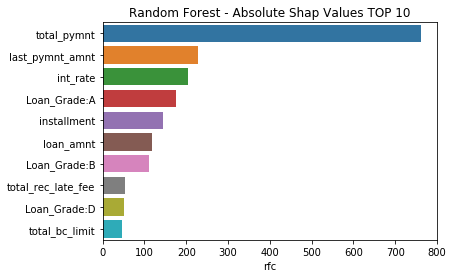

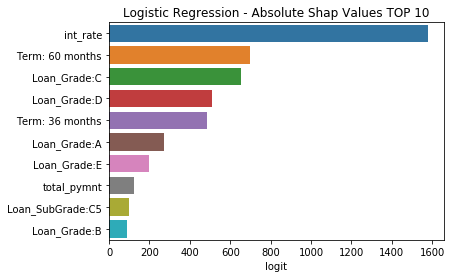

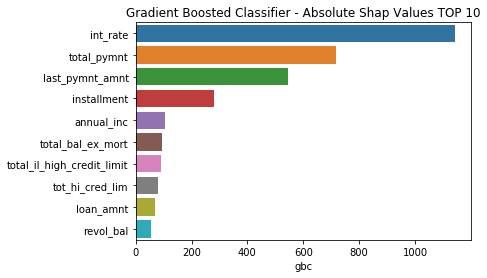

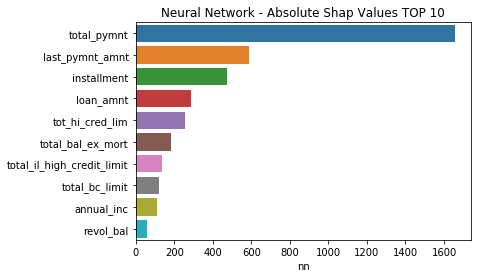

In [17]:
'''
Absolute and summation of shap values can be found @ obj/lendingclub/shap/ as csv files
The below will output the top ten ranked by absolute value, and the top and bottom 5 feats. by raw magnitude.
'''

from helpful_util import display_abs_shapvalues, display_shapvalues

display_abs_shapvalues(shapvalues=shap_values,
                       features=features,
                       num_features=10)

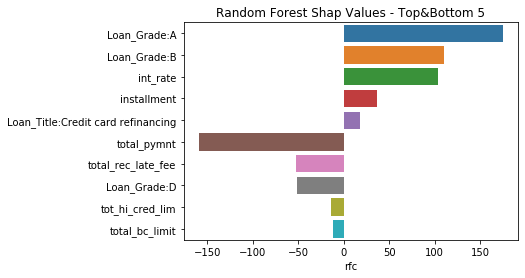

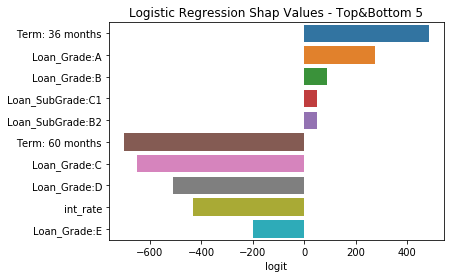

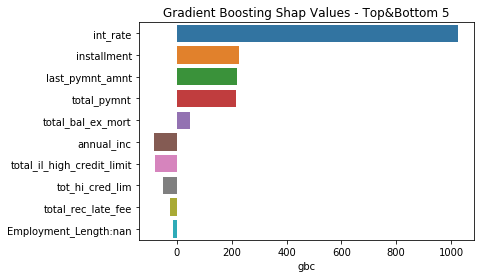

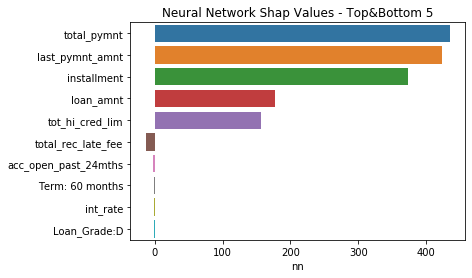

In [18]:
'''
For neural network below...
I believe we see the magnitudes in the negative direction lower here due to the low base value. Again,
Base value was computed as the probability of class 1 over the median of the columns in the train data.
This ended up being a predicted probability of ~6%. 
Because Shap is pred - baseline & our baseline is so low, it makes sense that there would be more push toward a more positive
model output - Atleast, that's what I'm thinking

'''

display_shapvalues(shapvalues=shap_values, features=features, n=10)

## Working with Integrated Gradients

In [39]:
#save_obj(keras_ig_df, 'keras_ig_df')
'''
#Leave Commented out. Code to generate integrated gradients attributions
from collections import OrderedDict

from IntegratedGradients import IntegratedGradients

ig = IntegratedGradients.integrated_gradients(keras_ann)


def fetch_grads(test_data):
    grads = []
    for i in test_data.toarray():
        grads.append(ig.explain(i, num_steps=1000))
    return pd.DataFrame(grads, columns=features)


keras_ig_df = fetch_grads(encoded_test)
save_obj(keras_ig_df, 'data_objects/keras_ig_df')

'''

keras_ig_df = load_obj('data_objects/keras_ig_df')

interactive(children=(Dropdown(description='features', options=('loan_amnt', 'int_rate', 'installment', 'annua…

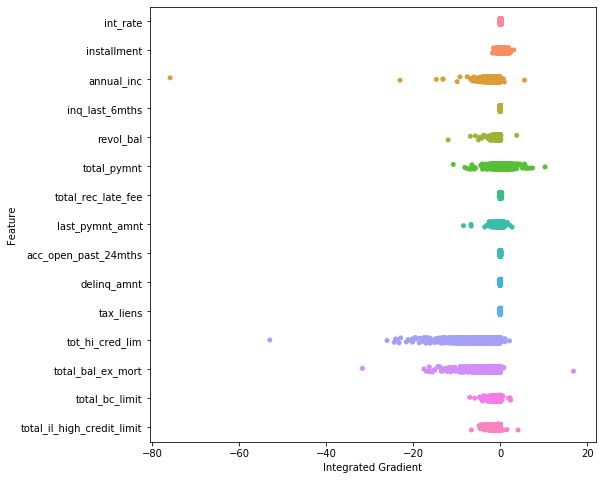

In [43]:
#Show integrated gradients of only continuous features
rcParams['figure.figsize'] = 8, 8

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
@interact
def shap_plot_summary_int(features=list(keras_ig_df[continuous].columns),
                          theme=list(cf.themes.THEMES.keys()),
                          colorscale=list(cf.colors._scales_names.keys())):

    return keras_ig_df[features].iplot(
        kind='area',
        theme=theme,
        xTitle='Observation',
        yTitle='Integrated Grad Value',
        title='Integrated Grad Value vs Observation, Feature: {}'.format(
            features),
        colorscale=colorscale)


df_sns = keras_ig_df.iloc[:, -15:].melt(var_name='groups', value_name='vals')
sns.stripplot(x="vals", y="groups", data=df_sns)
plt.xlabel('Integrated Gradient')
plt.ylabel('Feature')
plt.show()

## DeepExplain - Shapley/Saliency maps/Gradient * Input

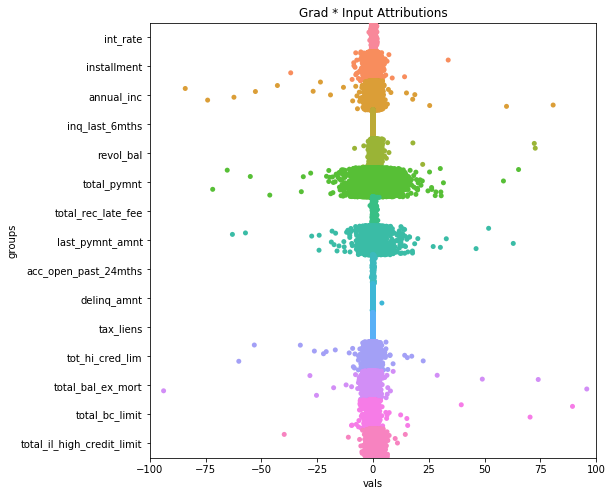

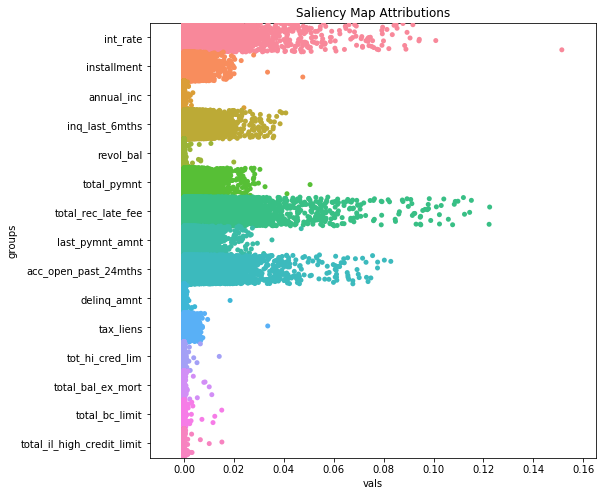

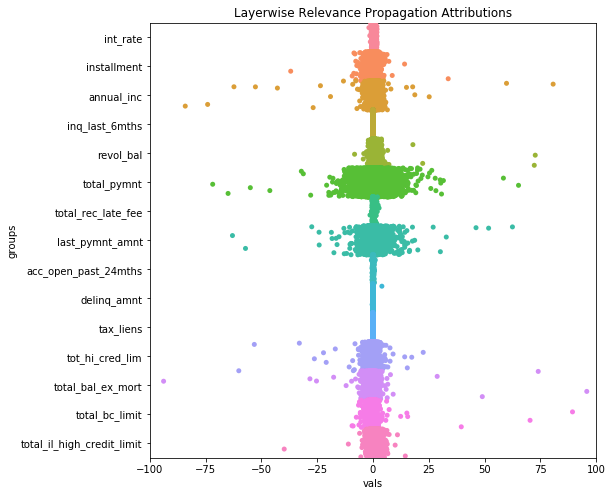

In [21]:
'''
Code to generate various attributions. Leave commented out. Objects stored locally.

#Code largely taken fron DeepExplain Git
#https://github.com/marcoancona/DeepExplain/blob/master/examples/mint_cnn_keras.ipynb
from deepexplain.tensorflow import DeepExplain
from keras import backend as K
from keras.models import Model
import tensorflow as tf

with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
#    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = keras_ann.layers[0].input

    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = keras_ann.layers[-2].output)
    target_tensor = fModel(input_tensor)

    xs = np.array(X_train_shap)
    ys = tf.keras.utils.to_categorical(y_train,2)

    attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys)
    attributions_sal   = de.explain('saliency', target_tensor, input_tensor, xs, ys=ys)
    #attributions_ig    = de.explain('intgrad', target_tensor, input_tensor, xs, ys=ys)
    #attributions_dl    = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys) #Deeplift. Incompatible w/ model arch.
    attributions_elrp  = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)
    #attributions_occ   = de.explain('occlusion', target_tensor, input_tensor, xs, ys=ys)

    # Compare Gradient * Input with approximate Shapley Values
    # Note1: Shapley Value sampling with 100 samples per feature (78400 runs) takes a couple of minutes on a GPU.
    # Note2: 100 samples are not enough for convergence, the result might be affected by sampling variance
    attributions_sv     = de.explain('shapley_sampling', target_tensor, input_tensor, xs, ys=ys, samples=500)

save_obj(attributions_gradin, 'attributions_gradin')
save_obj(attributions_sal, 'attributions_sal')
save_obj(attributions_elrp, 'attributions_elrp')
save_obj(attributions_sv, 'attributions_sv')
'''

#Removed dependency on DeepExplain.
#Can pip install -e git+https://github.com/marcoancona/DeepExplain.git#egg=deepexplain
attributions_gradin = load_obj('attributions_gradin')
attributions_sal = load_obj('attributions_sal')
attributions_elrp = load_obj('attributions_elrp')
attributions_sv = load_obj('attributions_sv')

#Load attributions and show columnwise dotplots. Note that we are only looking at the tail 14 features here.
deep_df = pd.DataFrame(attributions_gradin, columns=features)
deep_df = deep_df.iloc[:, -15:].melt(var_name='groups', value_name='vals')
ax = sns.stripplot(x="vals", y="groups", data=deep_df, jitter=.5)
plt.xlim(-100, 100)
plt.title('Grad * Input Attributions')
plt.show()

#deep_df = pd.DataFrame(attributions_sv, columns=features)
#deep_df = deep_df.iloc[:, -15:].melt(var_name='groups', value_name='vals')
#ax = sns.stripplot(x="vals", y="groups", data=deep_df, jitter = .5)
#plt.title('Shap Attributions')
#plt.show()

deep_df = pd.DataFrame(attributions_sal, columns=features)
deep_df = deep_df.iloc[:, -15:].melt(var_name='groups', value_name='vals')
ax = sns.stripplot(x="vals", y="groups", data=deep_df, jitter=.5)
plt.title('Saliency Map Attributions')
plt.show()

deep_df = pd.DataFrame(attributions_elrp, columns=features)
deep_df = deep_df.iloc[:, -15:].melt(var_name='groups', value_name='vals')
ax = sns.stripplot(x="vals", y="groups", data=deep_df, jitter=.5)
plt.xlim(-100, 100)
plt.title('Layerwise Relevance Propagation Attributions')
plt.show()

## GAM

In [56]:
'''
Put Shap values in the format GAM needs.
e.g., [shap values x features]
GAM auto drops header 
'''


def shap_to_csv(model, file_name):
    local = pd.DataFrame(shap_values[str(type(model))],
                         columns=features).iloc[:200,:]  #Sample 1000 rows of shap values
    local.to_csv('obj/lendingclub/gam/{}_local.csv'.format(file_name),
                 index=False)


#shap_to_csv(gbc, 'gbc')
#shap_to_csv(logit, 'logit')
#shap_to_csv(keras_ann, 'keras_ann')
#shap_to_csv(rfc, 'rfc')

shap_to_csv(gbc, 'gbc_200')
shap_to_csv(logit, 'logit_200')
shap_to_csv(keras_ann, 'keras_ann_200')
shap_to_csv(rfc, 'rfc_200')

In [59]:
from gam.gam.gam import GAM
'''
local shap values for all models are stored in the obj folder
change attributions_path based on which model you want to evaluate
    obj/lendingclub/gam/rfc_local.csv
    obj/lendingclub/gam/keras_ann_local.csv
    obj/lendingclub/gam/gbc_local.csv
    obj/lendingclub/gam/logit_local.csv
    
'''
#gam_keras =  GAM(attributions_path="obj/lendingclub/gam/keras_ann_local.csv", k=2)
#gam_keras_5clusters = GAM(
#    attributions_path="obj/lendingclub/gam/keras_ann_local.csv", k=2)
#gam_logit = GAM(attributions_path="obj/lendingclub/gam/logit_local.csv", k=2)
#gam_rfc = GAM(attributions_path="obj/lendingclub/gam/rfc_local.csv", k=2)
#gam_gbc = GAM(attributions_path="obj/lendingclub/gam/gbc_local.csv", k=2)

#gam_keras.generate()
#gam_keras_5clusters.generate()
#gam_logit.generate()
#gam_rfc.generate()
#gam_gbc.generate()

#save_obj(gam_keras, '/gam/gam_keras')
#save_obj(gam_keras_5clusters, '/gam/gam_keras_5clusters')

#save_obj(gam_logit, '/gam/gam_logit')
#save_obj(gam_rfc, '/gam/gam_rfc')
#save_obj(gam_gbc, '/gam/gam_gbc')

'\nlocal shap values for all models are stored in the obj folder\nchange attributions_path based on which model you want to evaluate\n    obj/lendingclub/gam/rfc_local.csv\n    obj/lendingclub/gam/keras_ann_local.csv\n    obj/lendingclub/gam/gbc_local.csv\n    obj/lendingclub/gam/logit_local.csv\n    \n'

				Showing GAM Explanation #1


,features,Feature Importance
84,tot_hi_cred_lim,0.168718
80,last_pymnt_amnt,0.158518
85,total_bal_ex_mort,0.151795
74,installment,0.147421
86,total_bc_limit,0.114940
77,revol_bal,0.100344
87,total_il_high_credit_limit,0.053768
72,loan_amnt,0.040153
73,int_rate,0.032176
81,acc_open_past_24mths,0.017912


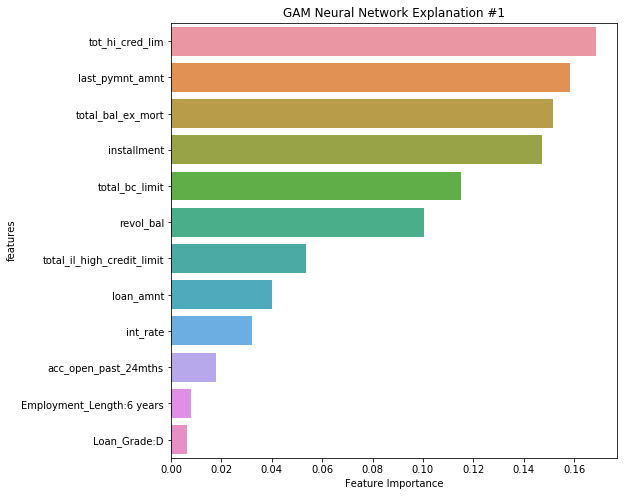

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
				Showing GAM Explanation #2


,features,Feature Importance
78,total_pymnt,0.196097
74,installment,0.157757
85,total_bal_ex_mort,0.152516
87,total_il_high_credit_limit,0.134655
72,loan_amnt,0.126816
86,total_bc_limit,0.086223
75,annual_inc,0.041262
81,acc_open_past_24mths,0.029919
3,Loan_Grade:B,0.023600
84,tot_hi_cred_lim,0.020607


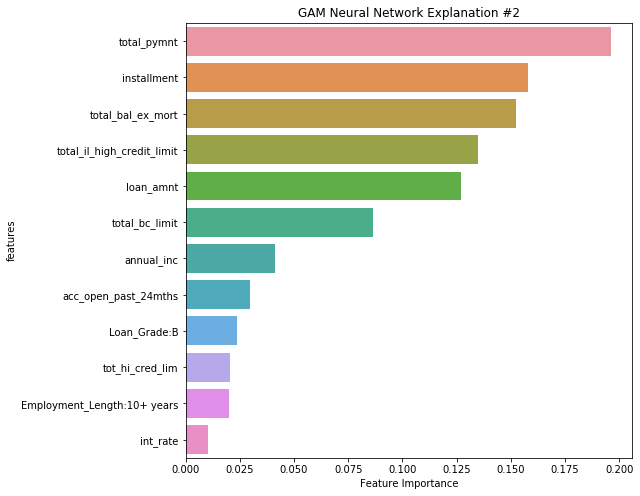

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


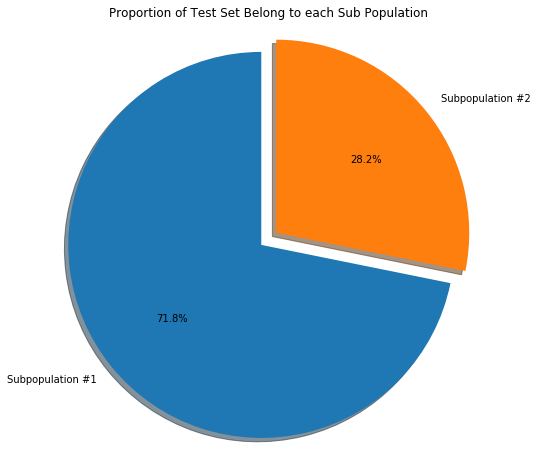

In [60]:
'''
Reload GAM objects + Plot all feature importance metrics for each of the explanations.
Plot shows: Top 2 Clusters and their top features

https://github.com/capitalone/global-attribution-mapping
'''
from IPython.display import display, HTML
gam_keras = load_obj('/gam/gam_keras')


for i in range(len(gam_keras.explanations)):
    print('\t\t\t\tShowing GAM Explanation #{}'.format(i + 1))
    gam_nn_df = pd.DataFrame(gam_keras.explanations[i],
                             columns=['features', 'Feature Importance'
                                      ]).sort_values(by='Feature Importance',
                                                     ascending=False)
    gam_nn_df = gam_nn_df[gam_nn_df['Feature Importance'] > 0]
    display(HTML(gam_nn_df.to_html()))
    sns.barplot(gam_nn_df['Feature Importance'], gam_nn_df['features'])
    plt.title('GAM Neural Network Explanation #{}'.format(i+1))
    plt.show()
    print('-' * 100)
    print('-' * 100)

labels = ['Subpopulation #1', 'Subpopulation #2']
sizes = [gam_keras.subpopulation_sizes[0] / sum(gam_keras.subpopulation_sizes) *100,
            gam_keras.subpopulation_sizes[1] / sum(gam_keras.subpopulation_sizes) *100]
explode = (0.1, 0.0)
fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Proportion of Test Set Belong to each Sub Population')
plt.show()